In [1]:
# Imports needed for analysis

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import requests
import json

**Four CSV files were provided**

Information from the HDB re-sale flats were provided in each csv file from 1990 to 2019. 

link to files: https://data.gov.sg/dataset/resale-flat-prices

# Goal of Project:

"The housing and development board (HDB) wants to understand the drivers of prices of the houses."

### Strategy:

**Dat Visualization & Engineering**
- Explore the data and create/ add new features to increase the complexity of the dataset

**Forecasting**
- Divide the dataset into regions and forecast sale prices for each region using Facebook Prophet

**Identifying drivers of the HDB resale market**
- Divide the temporal data into market growth categories (Growth, Constant, Correction)
- Add extra features, such as proximity to MRT & schools according to year
- Use regression models to predict 2019 prices 
- Use Coefficient or Feature Importance to identify top drivers of the Singaporean HDB housing market

# Basic Exploratory Data Analysis & Data Engineering

**Book #1 - Start of the project** 

**1) Concatenating the sales files**
- Resulting in 10 columns and 793596 HDB sales

In [2]:
set_1990 = pd.read_csv('./resale-flat-prices/resale-1990-1999.csv')
set_2000 = pd.read_csv('./resale-flat-prices/resale-2000-feb-2012.csv')
set_2012 = pd.read_csv('./resale-flat-prices/resale-mar-2012-to-dec-2014.csv')
set_2015 = pd.read_csv('./resale-flat-prices/resale-jan-2015-onwards.csv')

# remove column from 2015 that does not appear in the other datasets
set_2015.drop(columns = 'remaining_lease', inplace = True)

In [3]:
print('1990', list(set_1990.columns))
print('2000', list(set_2000.columns))
print('2012', list(set_2012.columns))
print('2015', list(set_2015.columns))

1990 ['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price']
2000 ['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price']
2012 ['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price']
2015 ['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price']


In [4]:
sales_df = pd.concat([set_1990,set_2000,set_2012,set_2015], axis = 0)
sales_df.head(5)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0


In [5]:
sales_df.tail(5)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
83593,2019-03,YISHUN,EXECUTIVE,359,YISHUN RING RD,04 TO 06,142.0,Apartment,1988,490000.0
83594,2019-03,YISHUN,EXECUTIVE,643,YISHUN ST 61,10 TO 12,142.0,Apartment,1987,500000.0
83595,2019-03,YISHUN,EXECUTIVE,641,YISHUN ST 61,07 TO 09,164.0,Apartment,1992,710888.0
83596,2019-03,YISHUN,EXECUTIVE,827,YISHUN ST 81,01 TO 03,145.0,Maisonette,1987,655000.0
83597,2019-03,YISHUN,EXECUTIVE,877,YISHUN ST 81,07 TO 09,145.0,Maisonette,1987,570000.0


In [6]:
sales_df.shape

(793596, 10)

In [7]:
sales_df.dtypes

month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
resale_price           float64
dtype: object

In [8]:
# save dataframe for Book #2
sales_df.to_csv('./resale-flat-prices/compiled_sales.csv')

**2) Column 1 - Change dates to DateTime format**

In [9]:
sales_df['month'] = pd.to_datetime(sales_df['month'], format ='%Y%m%')

In [10]:
# top 10 dates with the most flat sales
sales_df['month'].value_counts().head(10)

1999-03-01    6480
1999-06-01    5879
1998-10-01    5715
1999-04-01    5704
1999-05-01    5683
1999-07-01    5499
1999-08-01    5218
1998-11-01    5014
1998-12-01    5003
1999-02-01    4849
Name: month, dtype: int64

In [11]:
# years with the least sales
sales_df['month'].value_counts().tail(10)

1990-02-01    936
1991-04-01    927
2013-02-01    886
1990-09-01    868
1991-03-01    861
1991-06-01    840
1990-06-01    830
1991-02-01    824
1990-10-01    817
1990-05-01    786
Name: month, dtype: int64

In [12]:
# All the towns represented
sales_df['town'].value_counts()

TAMPINES           70778
YISHUN             60558
BEDOK              59656
JURONG WEST        58326
WOODLANDS          56315
ANG MO KIO         46907
HOUGANG            43836
BUKIT BATOK        39283
CHOA CHU KANG      32005
BUKIT MERAH        29397
PASIR RIS          29221
TOA PAYOH          27553
QUEENSTOWN         25201
CLEMENTI           25100
GEYLANG            24924
KALLANG/WHAMPOA    23276
BUKIT PANJANG      22654
JURONG EAST        22147
SENGKANG           20958
SERANGOON          20516
BISHAN             18940
PUNGGOL            10299
SEMBAWANG          10143
MARINE PARADE       7227
CENTRAL AREA        6114
BUKIT TIMAH         2198
LIM CHU KANG          64
Name: town, dtype: int64

In [13]:
# 27 different towns representated
print('Total Number of Towns: ', sales_df['town'].nunique())

Total Number of Towns:  27


In [14]:
# Replace MULTI GENERATION TO MULTI-GENERATION
sales_df['flat_type'].replace('MULTI GENERATION', 'MULTI-GENERATION', inplace=True)
sales_df['flat_type'].value_counts()

4 ROOM              295362
3 ROOM              264456
5 ROOM              162557
EXECUTIVE            60270
2 ROOM                9206
1 ROOM                1260
MULTI-GENERATION       485
Name: flat_type, dtype: int64

In [15]:
sales_df.groupby('street_name').agg(['mean','count']).sort_values(by = 'street_name').head(30)

floor_area_sqm        lease_commence_date         \
                            mean  count                mean  count   
street_name                                                          
ADMIRALTY DR          111.289626   1899         2001.132175   1899   
ADMIRALTY LINK         97.865812   1170         2003.644444   1170   
AH HOOD RD            118.176101    159         1981.000000    159   
ALEXANDRA RD           71.812500     64         1972.000000     64   
ALJUNIED CRES          73.655075   2128         1978.820489   2128   
ALJUNIED RD           121.000000    165         1983.000000    165   
ANCHORVALE DR         102.151832    764         2001.751309    764   
ANCHORVALE LANE       109.358491    318         2002.000000    318   
ANCHORVALE LINK       103.084721   1381         2002.110789   1381   
ANCHORVALE RD         107.645973   1192         2002.380034   1192   
ANG MO KIO AVE 1       78.866402   4536         1979.662698   4536   
ANG MO KIO AVE 10      80.782216  12618         1979.845142  12618   
ANG MO KIO AVE 2       97.361314    274         1979.532847    274   
ANG MO KIO AVE 3       79.460065  11068         1978.474702  11068   
ANG MO KIO AVE 4       80.819840   6633         1981.181366   6633   
ANG MO KIO AVE 5       80.266303   5873         1980.380555   5873   
ANG MO KIO AVE 6       86.484341   2267         1982.235554   2267   
ANG MO KIO AVE 8       74.930495   1597         1980.539762   1597   
ANG MO KIO AVE 9       92.352021    767         1980.762712    767   
ANG MO KIO ST 11      136.651163     86         1996.000000     86   
ANG MO KIO ST 21      135.099099    111         1996.000000    111   
ANG MO KIO ST 31      109.523466    277         2002.794224    277   
ANG MO KIO ST 32      100.191327    392         2001.000000    392   
ANG MO KIO ST 52      100.306373    408         2005.365196    408   
BAIN ST                82.000000    155         1980.000000    155   
BALAM RD               68.761681   1618         1973.477132   1618   
BANGKIT RD            103.843566   1873         1988.134544   1873   
BEACH RD               70.779197    548         1977.919708    548   
BEDOK CTRL             89.331707    205         2010.000000    205   
BEDOK NTH AVE 1        76.763071   2123         1979.772963   2123   

                    resale_price         
                            mean  count  
street_name                              
ADMIRALTY DR       370505.028963   1899  
ADMIRALTY LINK     337895.727350   1170  
AH HOOD RD         417345.836478    159  
ALEXANDRA RD       122954.062500     64  
ALJUNIED CRES      213246.210526   2128  
ALJUNIED RD        391496.290909    165  
ANCHORVALE DR      395181.438482    764  
ANCHORVALE LANE    406293.229560    318  
ANCHORVALE LINK    399330.180941   1381  
ANCHORVALE RD      413360.112416   1192  
ANG MO KIO AVE 1   223117.181658   4536  
ANG MO KIO AVE 10  221407.718022  12618  
ANG MO KIO AVE 2   274334.569343    274  
ANG MO KIO AVE 3   224502.203368  11068  
ANG MO KIO AVE 4   219835.353933   6633  
ANG MO KIO AVE 5   216893.404352   5873  
ANG MO KIO AVE 6   276005.773216   2267  
ANG MO KIO AVE 8   214417.604884   1597  
ANG MO KIO AVE 9   265000.484068    767  
ANG MO KIO ST 11   525954.511628     86  
ANG MO KIO ST 21   457317.729730    111  
ANG MO KIO ST 31   577049.747292    277  
ANG MO KIO ST 32   485362.653061    392  
ANG MO KIO ST 52   640325.531863    408  
BAIN ST            408117.187097    155  
BALAM RD           190778.978986   1618  
BANGKIT RD         257594.852109   1873  
BEACH RD           238536.226277    548  
BEDOK CTRL         621199.921951    205  
BEDOK NTH AVE 1    207161.882242   2123

In [17]:
sales_df.reset_index(drop = True, inplace = True)

In [26]:
sales_df.groupby('storey_range')[['resale_price']].agg(['mean','count'])

resale_price        
                      mean   count
storey_range                      
01 TO 03      2.694772e+05  162905
01 TO 05      4.305680e+05    2700
04 TO 06      2.740716e+05  201951
06 TO 10      4.515410e+05    2474
07 TO 09      2.764606e+05  182316
10 TO 12      2.828890e+05  154211
11 TO 15      4.705736e+05    1259
13 TO 15      3.332321e+05   49066
16 TO 18      3.798994e+05   17941
16 TO 20      5.536002e+05     265
19 TO 21      4.051237e+05    8825
21 TO 25      6.315790e+05      92
22 TO 24      4.470606e+05    5588
25 TO 27      5.036659e+05    2284
26 TO 30      6.847250e+05      39
28 TO 30      6.290357e+05     902
31 TO 33      7.807084e+05     208
31 TO 35      7.065000e+05       2
34 TO 36      7.971167e+05     219
36 TO 40      7.178411e+05       7
37 TO 39      8.096918e+05     207
40 TO 42      8.283833e+05     100
43 TO 45      1.002917e+06      12
46 TO 48      9.897188e+05      16
49 TO 51      9.822526e+05       7

In [27]:
# Convention for the Floor range

storey1_10 = ['01 TO 03', '01 TO 05', '04 TO 06', '06 TO 10', '07 TO 09']
storey10_20 = ['10 TO 12', '11 TO 15', '13 TO 15', '16 TO 18', '16 TO 20', '19 TO 21']
storey20_30 = ['21 TO 25', '22 TO 24', '25 TO 27', '26 TO 30', '28 TO 30']
storey30_40 = ['31 TO 33', '31 TO 35', '34 TO 36', '36 TO 40', '37 TO 39']
storey40_50 = ['40 TO 42', '43 TO 45', '46 TO 48', '49 TO 51']

sales_df['storey_range'].replace(storey1_10, '1-10', inplace = True)
sales_df['storey_range'].replace(storey10_20, '10-20', inplace = True)
sales_df['storey_range'].replace(storey20_30, '20-30', inplace = True)
sales_df['storey_range'].replace(storey30_40, '30-40', inplace = True)
sales_df['storey_range'].replace(storey40_50, '40-50', inplace = True)

sales_df.groupby('storey_range')[['resale_price']].agg(['mean','count'])

resale_price        
                       mean   count
storey_range                       
1-10          275065.020165  552346
10-20         307060.622858  231567
20-30         482958.713267    8905
30-40         794712.292379     643
40-50         870997.007407     135

In [28]:
sales_df['flat_model'] = sales_df['flat_model'].apply(lambda x : x.lower())

In [29]:
sales_df.groupby('flat_model')[['resale_price', 'floor_area_sqm', 'lease_commence_date']].agg(['mean', 'std', 'count'])

resale_price                        floor_area_sqm  \
                                mean            std   count           mean   
flat_model                                                                   
2-room                  1.308263e+05   74698.224170      38      50.736842   
adjoined flat           3.065200e+05  223566.581615    1963     138.665308   
apartment               4.800674e+05  110727.344517   30718     146.881372   
dbss                    7.869547e+05  132767.218164     975     105.034872   
improved                3.001519e+05  149101.398116  208907      97.277728   
improved-maisonette     4.201691e+05  163912.040648     111     136.297297   
maisonette              4.703948e+05  142175.194643   25908     148.377737   
model a                 2.936984e+05  120102.192040  216700      98.845353   
model a-maisonette      4.190616e+05  161750.445612    1822     141.312294   
model a2                2.816636e+05   75313.506590    8756      89.952147   
multi generation        4.931440e+05  158334.672331     485     161.839175   
new generation          2.078030e+05   97659.124366  173144      78.055173   
premium apartment       4.045591e+05  104251.309685   31436     108.051120   
premium apartment loft  8.235576e+05   63623.877340      10     148.000000   
premium apartment.      3.916368e+05   66908.488865      93      83.279570   
premium maisonette      5.814558e+05  103290.784961      75     163.013333   
simplified              2.180169e+05   89054.279013   52624      79.653694   
standard                2.295777e+05  163628.657856   38878      76.532674   
terrace                 4.900236e+05  210726.140787     622     120.480707   
type s1                 8.822081e+05   55910.781203     223      94.309417   
type s2                 1.001824e+06   70337.143166     108     106.194444   

                                          lease_commence_date             \
                              std   count                mean        std   
flat_model                                                                 
2-room                   6.176171      38         1985.000000  11.909569   
adjoined flat           18.492982    1963         1977.300051   4.878768   
apartment               11.272589   30718         1993.796862   4.112113   
dbss                    12.553983     975         2010.721026   1.436585   
improved                27.438826  208907         1985.367704  10.189211   
improved-maisonette      3.415458     111         1983.126126   1.328821   
maisonette               4.984233   25908         1988.401768   3.890495   
model a                 15.975513  216700         1991.116114   6.904418   
model a-maisonette       4.686510    1822         1983.951153   0.499672   
model a2                 4.030763    8756         1999.128026   1.902401   
multi generation        11.719823     485         1987.068041   0.252077   
new generation          12.001374  173144         1981.265224   3.082612   
premium apartment       13.883971   31436         2002.375048   3.805240   
premium apartment loft   1.054093      10         2012.500000   0.527046   
premium apartment.      13.052874      93         2015.000000   0.000000   
premium maisonette      23.150794      75         1997.440000   0.499730   
simplified               8.830847   52624         1986.766494   1.821807   
standard                30.308591   38878         1972.826663   4.557805   
terrace                 48.606429     622         1971.086817   1.680288   
type s1                  1.181025     223         2011.000000   0.000000   
type s2                  0.847849     108         2011.000000   0.000000   

                                
                         count  
flat_model                      
2-room                      38  
adjoined flat             1963  
apartment                30718  
dbss                       975  
improved                208907  
improved-maisonette        111  
maisonette               2590

In [30]:
#make a column of price per sqft
sales_df['resale_price_psf'] = sales_df['resale_price'] / sales_df['floor_area_sqm'] 

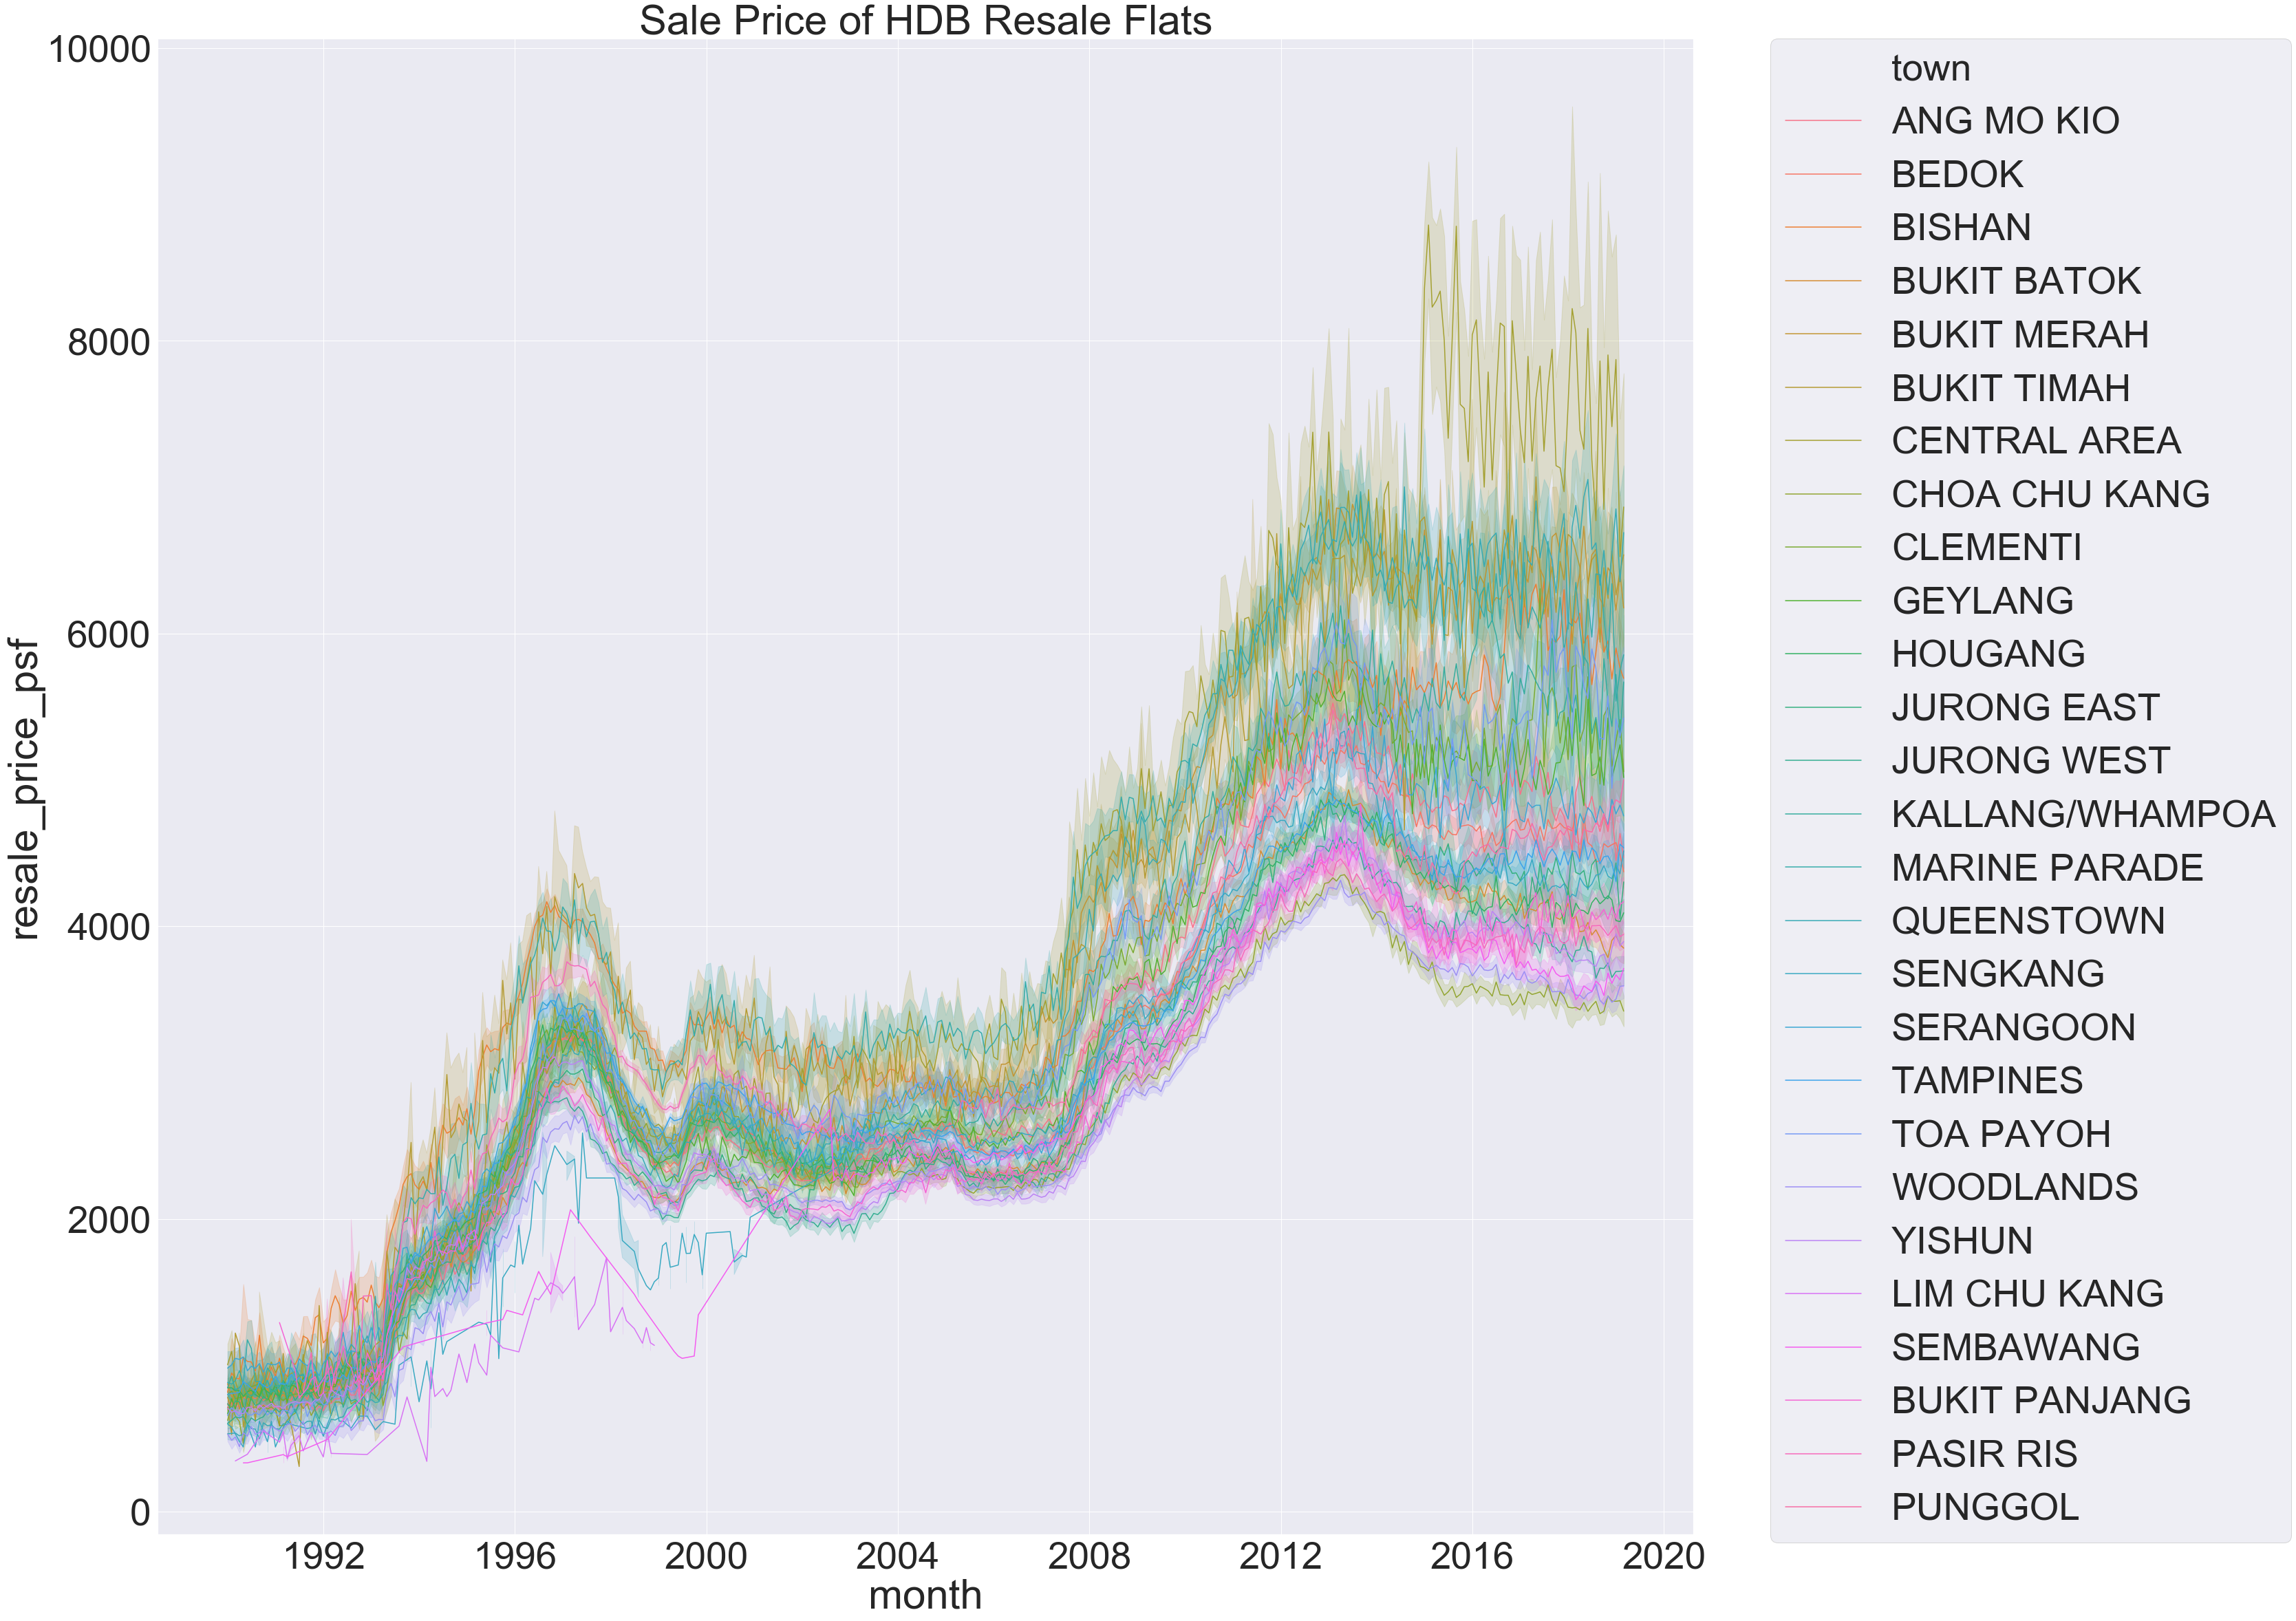

In [120]:
sns.set(rc={'figure.figsize':(40,40)}, font_scale = 5)
sns.lineplot(x = 'month', y = 'resale_price_psf', data = sales_df, hue = 'town')
plt.title('Sale Price of HDB Resale Flats')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 1.0, 'Sale Price of HDB Resale Flats')

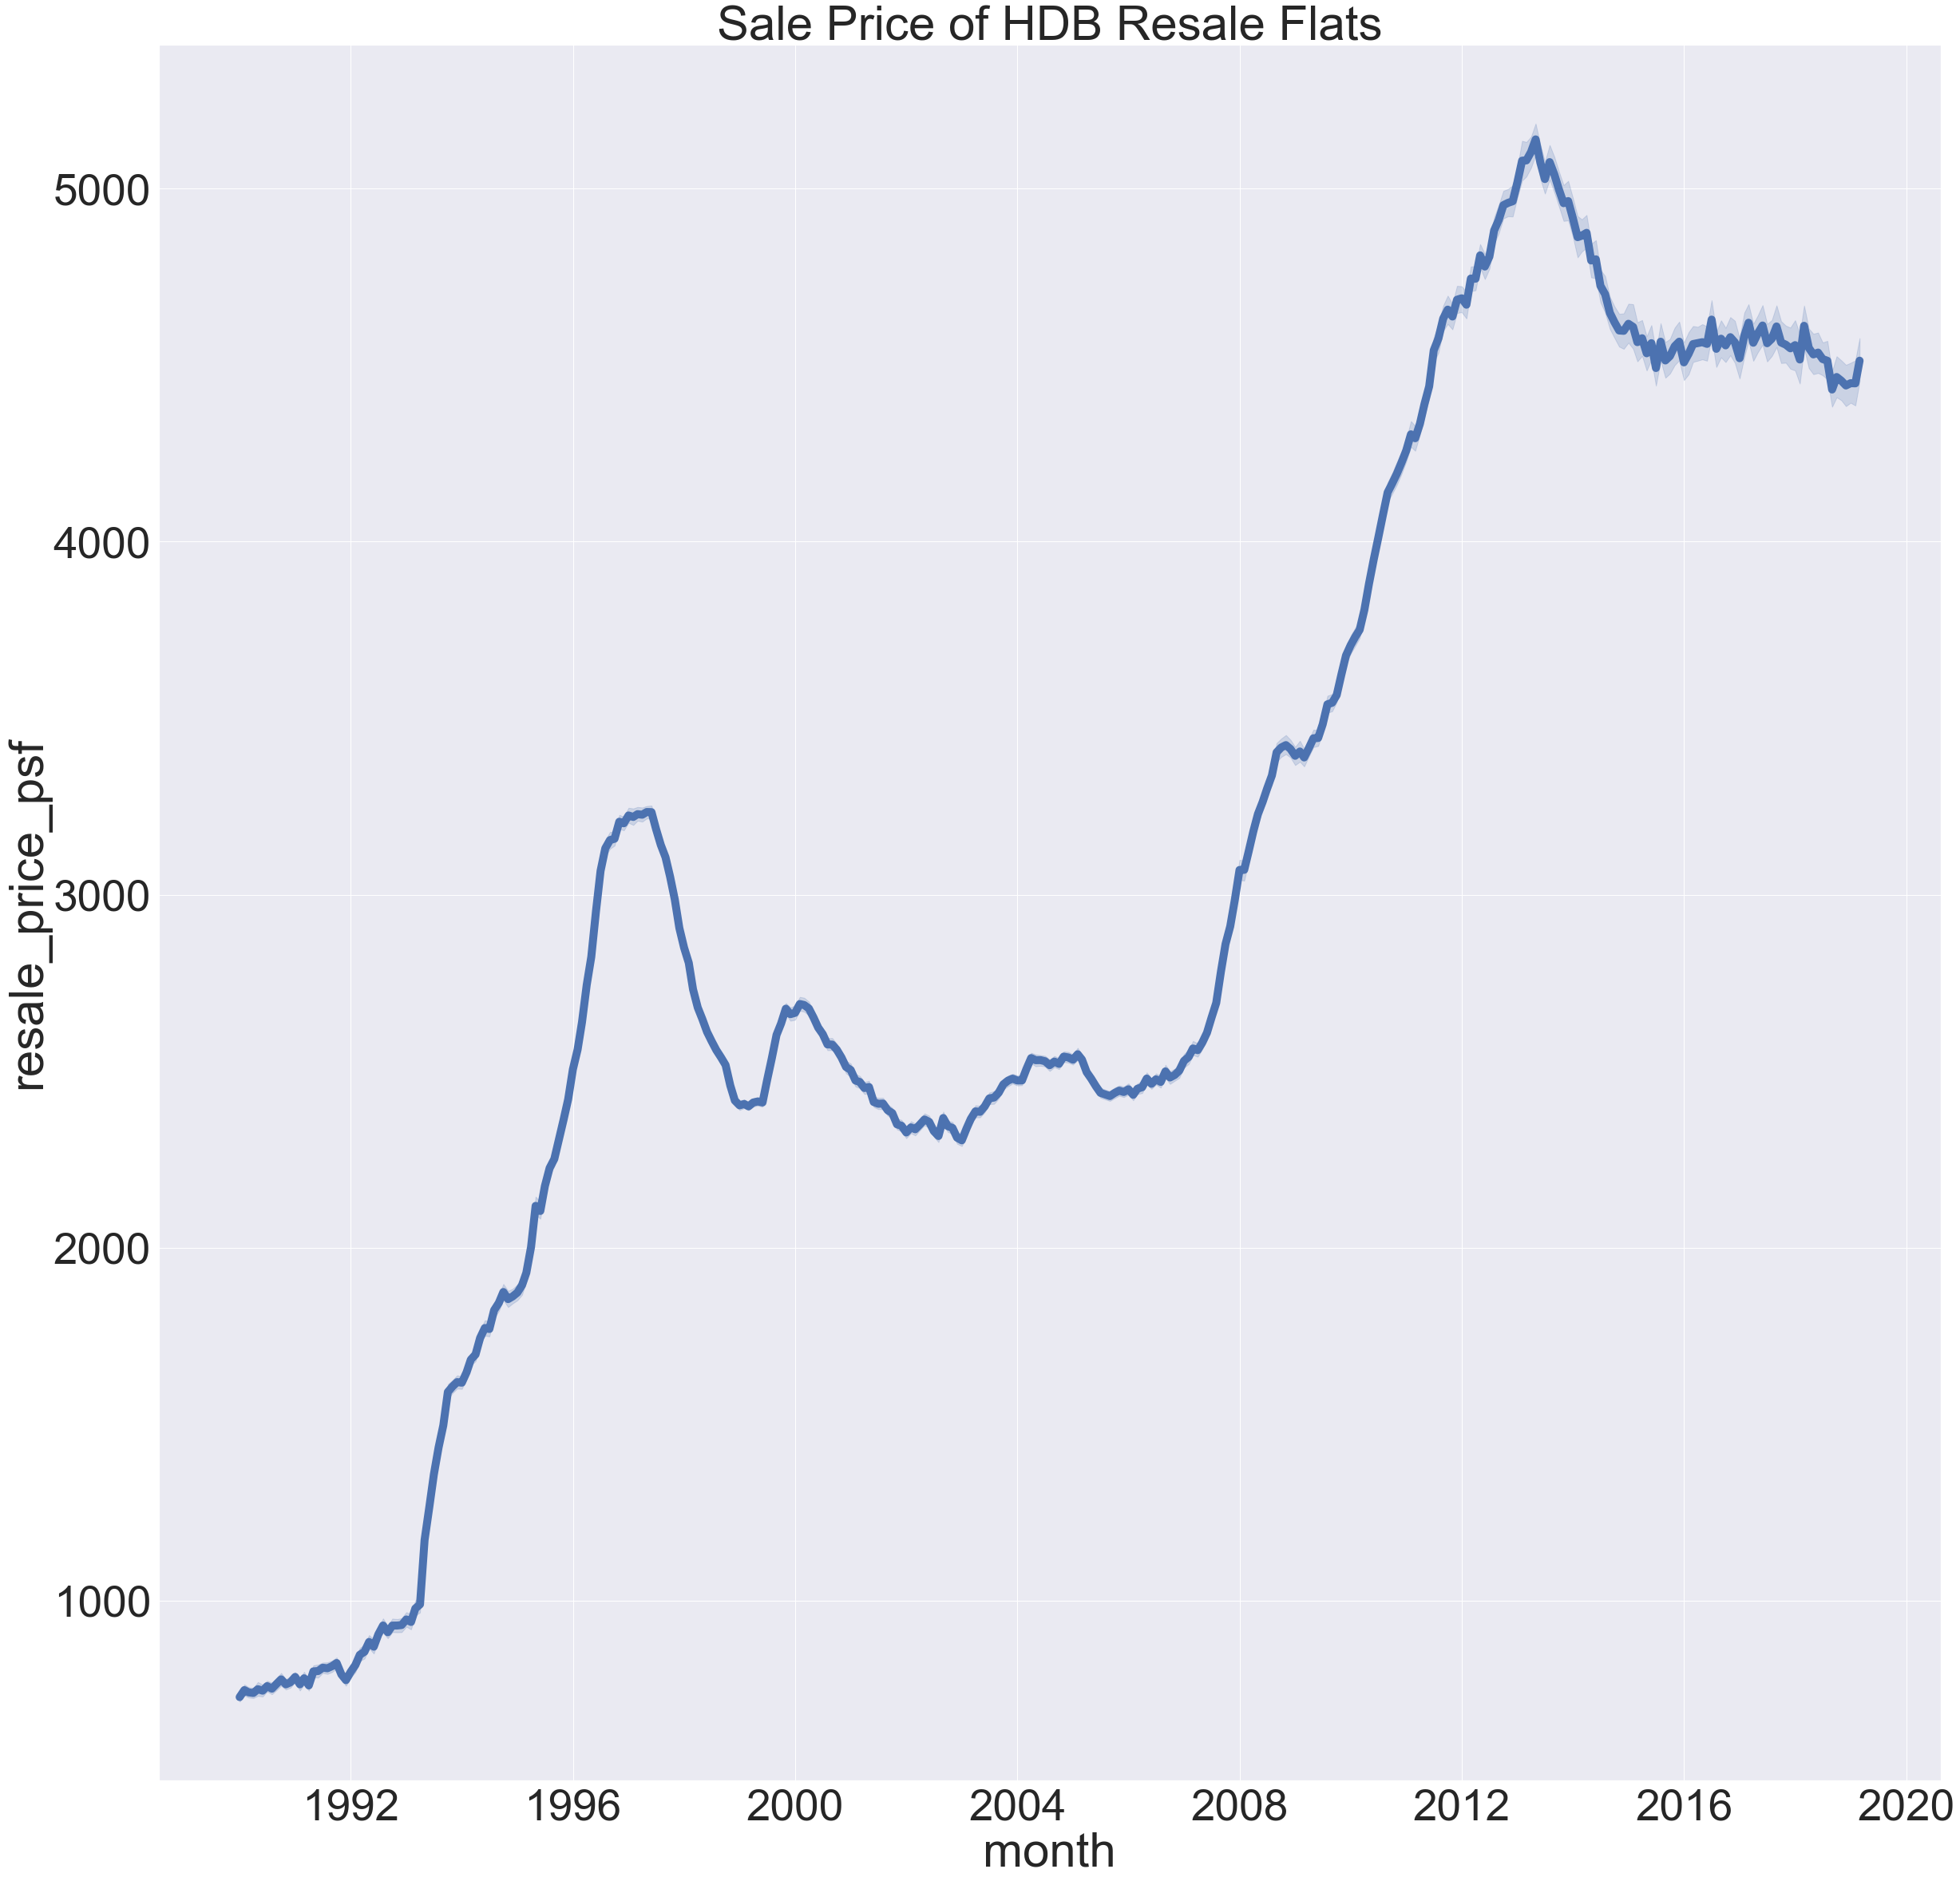

In [125]:
sns.set(rc={'figure.figsize':(40,40), "lines.linewidth": 10}, font_scale = 5)
sns.lineplot(x = 'month', y = 'resale_price_psf', data = sales_df)
plt.title('Sale Price of HDB Resale Flats')

In [115]:
# Make new Columns : Month Sold and Year Sold

sales_df['year'] = pd.DatetimeIndex(sales_df['month']).year
sales_df['Month'] = pd.DatetimeIndex(sales_df['month']).month

# New column : Remaining Lease

sales_df['remaining_lease'] =  99 - (sales_df['year'] - sales_df['lease_commence_date'])

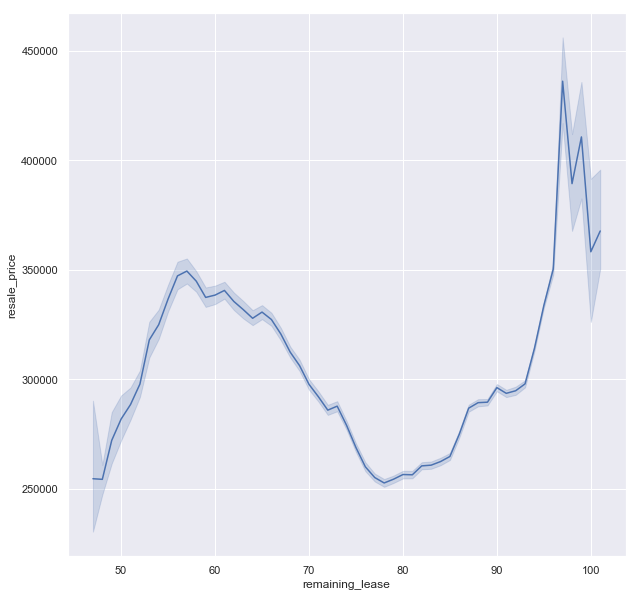

In [116]:
sns.lineplot(x = 'remaining_lease', y = 'resale_price', data = sales_df)

In [48]:
# Cleaning Street Names for Geo-tagging
sales_df['street_name'].replace("C'WEALTH CL", 'Commonwealth Clos', inplace = True)

In [49]:
# New column for full street address:

sales_df['full_address'] = sales_df['block'] + ' ' + sales_df['street_name'] + ' ' + 'Singapore'

## GEOLOCATIONS FOR HDB

In [51]:
# DataFrame of unique addresses for geolocations
unique_addresses = sales_df.drop_duplicates(subset=('full_address')).copy()

In [52]:
len(unique_addresses)

8951

In [53]:
unique_addresses['full_address'][:10]

0     309 ANG MO KIO AVE 1 Singapore
4     216 ANG MO KIO AVE 1 Singapore
5     211 ANG MO KIO AVE 3 Singapore
6     202 ANG MO KIO AVE 3 Singapore
7     235 ANG MO KIO AVE 3 Singapore
9     232 ANG MO KIO AVE 3 Singapore
11    308 ANG MO KIO AVE 1 Singapore
13    220 ANG MO KIO AVE 1 Singapore
14    219 ANG MO KIO AVE 1 Singapore
15    247 ANG MO KIO AVE 3 Singapore
Name: full_address, dtype: object

In [53]:
# Using the Geocoder API HERE

# Try a single location first
app_id = 'oNl8woOVdyFoQwpSWkN6'
app_code = 'fEiZhmTK7OeXOw2osuA1xg'
address = unique_addresses['full_address'][0]

resp = requests.get('https://geocoder.api.here.com/6.2/geocode.json?app_id={}&app_code={}&searchtext={}'.format(app_id,app_code,address))
resp.status_code

In [66]:
json.loads(resp.text)

In [70]:
# Latitude and Longitude for this address 
print(json.loads(resp.text)['Response']['View'][0]['Result'][0]['Location']['NavigationPosition'][0]['Latitude'])
print(json.loads(resp.text)['Response']['View'][0]['Result'][0]['Location']['NavigationPosition'][0]['Longitude'])

1.3660701
103.8448399


In [79]:
# Def function to retrive latitude and longitude

def retrieve_lat_long(series):

    json_responses = {}
    
    addresses = []
    latitudes = []
    longitudes = []
    
    #
    app_id = 'oNl8woOVdyFoQwpSWkN6'
    app_code = 'fEiZhmTK7OeXOw2osuA1xg'
    
    #Iterate through the series of addresses
    for i,address in enumerate(series):
        #request geodata from HERE maps API
        response = requests.get("https://geocoder.api.here.com/6.2/geocode.json?app_id={}&app_code={}&searchtext={}".format(app_id, app_code, address))
        
        #if request is successful, save the full geodata JSON (keep the full data just in case)  
        if response.status_code == 200:
            json_responses[address]=json.loads(response.text)
            
            #Append the address, latitude and longitude information
            addresses.append(address)
            try:
                latitudes.append(json.loads(response.text)['Response']['View'][0]['Result'][0]['Location']['NavigationPosition'][0]['Latitude'])
            except:
                print('Unable to save latitude from: {}'.format(address))
                latitudes.append(None)
            try:
                longitudes.append(json.loads(response.text)['Response']['View'][0]['Result'][0]['Location']['NavigationPosition'][0]['Longitude'])
            except:
                print('Unable to save longtitude from: {}'.format(address))
                longitudes.append(None)
        else:
            #if response fails, print the address and the corresponding status code
            print(address, 'status: ', response.status_code)
            
            #Record JSON and geodata information as None
            json_responses[address]=None
            adresses.append(address)
            latitudes.append(None)
            longitudes.append(None)
        
        #Save retrieved information periodically
        if i%250 == 0:
            print('Saving JSON, {} addresses done.'.format(i+1),end=' ')
            
            #Save the full JSON response as text file (do not overwrite, have back-ups)
            with open('json_save_{}.txt'.format(i), 'w') as outfile:  
                json.dump(json_responses, outfile)
            
            #Create the DataFrame and save as csv (do not overwrite, have back-ups)
            lat_long = pd.DataFrame({'Address':addresses,'Latitude':latitudes,'Longitude':longitudes})
            lat_long.to_csv('lat_long_{}.csv'.format(i))
    
    #After all addresses are complete, print message
    print('Saving JSON, {} addresses done. All addresses completed.'.format(i+1))
            
    #Save the full JSON response as text file 
    with open('json_save_complete.txt', 'w') as outfile:  
        json.dump(json_responses, outfile)
        
    #Create the DataFrame and save as csv
    lat_long = pd.DataFrame({'Address':addresses,'Latitude':latitudes,'Longitude':longitudes})
    lat_long.to_csv('lat_long_complete.csv')

In [82]:
# Try with 10 addresses first
retrieve_lat_long(unique_addresses['full_address'][:10])

Saving JSON, 1 addresses done. Saving JSON, 10 addresses done. All addresses completed.


In [83]:
#Retrieve all HDB
retrieve_lat_long(unique_addresses['full_address'])

Saving JSON, 1 addresses done. Saving JSON, 251 addresses done. Unable to save latitude from: 1 JLN PASAR BARU Singapore
Unable to save longtitude from: 1 JLN PASAR BARU Singapore
Saving JSON, 501 addresses done. Saving JSON, 751 addresses done. Saving JSON, 1001 addresses done. Saving JSON, 1251 addresses done. Saving JSON, 1501 addresses done. Saving JSON, 1751 addresses done. Unable to save latitude from: 51 NILE RD Singapore
Unable to save longtitude from: 51 NILE RD Singapore
Unable to save latitude from: 54 NILE RD Singapore
Unable to save longtitude from: 54 NILE RD Singapore
Unable to save latitude from: 24 JLN MEMBINA BARAT Singapore
Unable to save longtitude from: 24 JLN MEMBINA BARAT Singapore
Saving JSON, 2001 addresses done. Unable to save latitude from: 5 BUANGKOK STH FARMWAY 1 Singapore
Unable to save longtitude from: 5 BUANGKOK STH FARMWAY 1 Singapore
Saving JSON, 2251 addresses done. Saving JSON, 2501 addresses done. Saving JSON, 2751 addresses done. Saving JSON, 3001 

In [36]:
data = pd.read_csv('./resale-flat-prices/lat_long_complete.csv',index_col=0)
data.head(10)

,Address,Latitude,Longitude
0,309 ANG MO KIO AVE 1 Singapore,1.36607,103.844840
1,216 ANG MO KIO AVE 1 Singapore,1.36582,103.841450
2,211 ANG MO KIO AVE 3 Singapore,1.36874,103.840980
3,202 ANG MO KIO AVE 3 Singapore,1.36833,103.844150
4,235 ANG MO KIO AVE 3 Singapore,1.36762,103.837090
5,232 ANG MO KIO AVE 3 Singapore,1.36830,103.836920
6,308 ANG MO KIO AVE 1 Singapore,1.36562,103.843875
7,220 ANG MO KIO AVE 1 Singapore,1.36587,103.840120
8,219 ANG MO KIO AVE 1 Singapore,1.36616,103.840640
9,247 ANG MO KIO AVE 3 Singapore,1.36823,103.833910


In [38]:
# Are there any missing geo coordinates ?
data.sort_values(by = 'Latitude').tail(10)

,Address,Latitude,Longitude
7989,491 ADMIRALTY LINK Singapore,1.45665,103.81778
8054,493 ADMIRALTY LINK Singapore,1.45670,103.81654
7970,485 ADMIRALTY LINK Singapore,1.45678,103.81572
8070,492 ADMIRALTY LINK Singapore,1.45684,103.81707
8023,484 ADMIRALTY LINK Singapore,1.45691,103.81516
488,1 JLN PASAR BARU Singapore,NaN,NaN
1924,51 NILE RD Singapore,NaN,NaN
1925,54 NILE RD Singapore,NaN,NaN
1926,24 JLN MEMBINA BARAT Singapore,NaN,NaN
2039,5 BUANGKOK STH FARMWAY 1 Singapore,NaN,NaN


In [44]:
# manual entries for three buildings. 
# The Nile Rd could not be found in Singapore 

# 5 BUANGKOK STH FARMWAY 1 Singapore
data.loc[2039,'Latitude'] = 1.384980
data.loc[2039,'Longitude'] = 103.936340

# 24 JLN MEMBINA BARAT Singapore
data.loc[1926,'Latitude'] = 1.283470
data.loc[1926,'Longitude'] = 103.826670

# 1 JLN PASAR BARU Singapore
data.loc[488,'Latitude'] = 1.317270
data.loc[488,'Longitude'] = 103.897510

# Remove Nile Rd
data = data.drop([1924,1925])

In [45]:
# Are there any missing geo coordinates ?
data.sort_values(by = 'Latitude').tail(10)

,Address,Latitude,Longitude
8880,463C SEMBAWANG DR Singapore,1.45599,103.81376
8250,466D SEMBAWANG DR Singapore,1.45607,103.81375
8871,463B SEMBAWANG DR Singapore,1.45617,103.81373
8238,466C SEMBAWANG DR Singapore,1.45626,103.81366
8024,486 ADMIRALTY LINK Singapore,1.45626,103.81604
7989,491 ADMIRALTY LINK Singapore,1.45665,103.81778
8054,493 ADMIRALTY LINK Singapore,1.45670,103.81654
7970,485 ADMIRALTY LINK Singapore,1.45678,103.81572
8070,492 ADMIRALTY LINK Singapore,1.45684,103.81707
8023,484 ADMIRALTY LINK Singapore,1.45691,103.81516


In [46]:
# update the csv file with the new lat long coordinates
data.reset_index(inplace = True, drop = True)
data.to_csv('lat_long_complete.csv')

## Make Three Datasets & include Latitude & Longtide to each dataset

In [55]:
sales_df.head(10)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,region,resale_price_psf,year,Month,remaining_lease,full_address
0,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10-20,31.0,improved,1977,9000.0,North,290.322581,1990,1,13,309 ANG MO KIO AVE 1 Singapore
1,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,1-10,31.0,improved,1977,6000.0,North,193.548387,1990,1,13,309 ANG MO KIO AVE 1 Singapore
2,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10-20,31.0,improved,1977,8000.0,North,258.064516,1990,1,13,309 ANG MO KIO AVE 1 Singapore
3,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,1-10,31.0,improved,1977,6000.0,North,193.548387,1990,1,13,309 ANG MO KIO AVE 1 Singapore
4,1990-01-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,1-10,73.0,new generation,1976,47200.0,North,646.575342,1990,1,14,216 ANG MO KIO AVE 1 Singapore
5,1990-01-01,ANG MO KIO,3 ROOM,211,ANG MO KIO AVE 3,1-10,67.0,new generation,1977,46000.0,North,686.567164,1990,1,13,211 ANG MO KIO AVE 3 Singapore
6,1990-01-01,ANG MO KIO,3 ROOM,202,ANG MO KIO AVE 3,1-10,67.0,new generation,1977,42000.0,North,626.865672,1990,1,13,202 ANG MO KIO AVE 3 Singapore
7,1990-01-01,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,10-20,67.0,new generation,1977,38000.0,North,567.164179,1990,1,13,235 ANG MO KIO AVE 3 Singapore
8,1990-01-01,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,1-10,67.0,new generation,1977,40000.0,North,597.014925,1990,1,13,235 ANG MO KIO AVE 3 Singapore
9,1990-01-01,ANG MO KIO,3 ROOM,232,ANG MO KIO AVE 3,1-10,67.0,new generation,1977,47000.0,North,701.492537,1990,1,13,232 ANG MO KIO AVE 3 Singapore


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


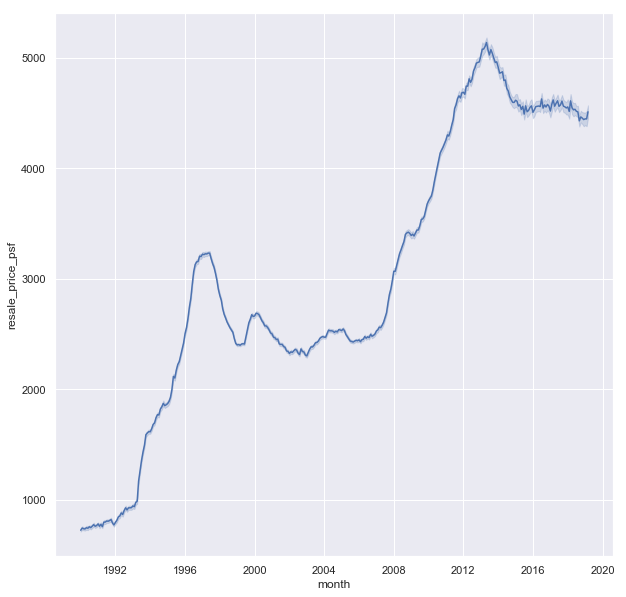

In [56]:
sns.set(rc={'figure.figsize':(10,10)})
sns.lineplot(x = 'month', y = 'resale_price_psf', data = sales_df)


/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


Text(0.5, 0, 'Date')

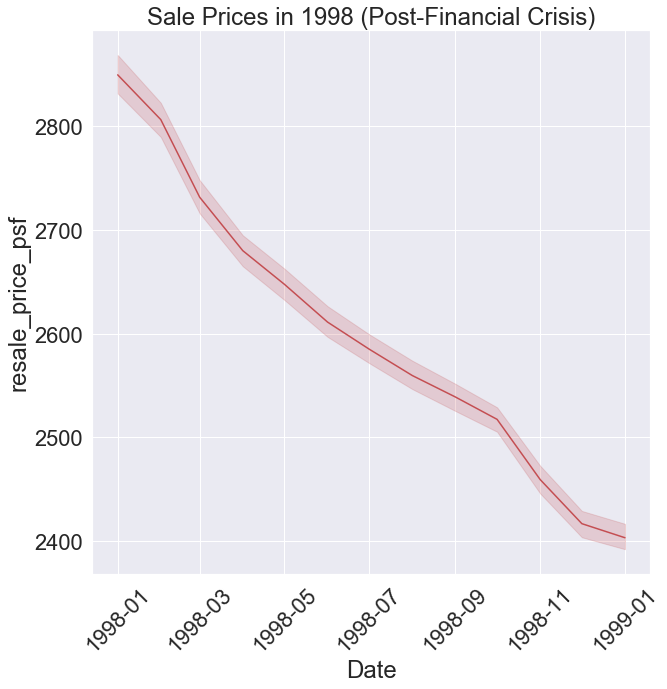

In [132]:
sales_low = sales_df[sales_df['month'].between('1998-01-01', '1999-01-01')]

sns.set(rc={'figure.figsize':(10,10)}, font_scale = 2)
sns.lineplot(x = 'month', y = 'resale_price_psf', data = sales_low, c = 'r')
plt.title('Sale Prices in 1998 (Post-Financial Crisis)')
plt.xticks(rotation = 45)
plt.xlabel('Date')

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


Text(0.5, 0, 'Date')

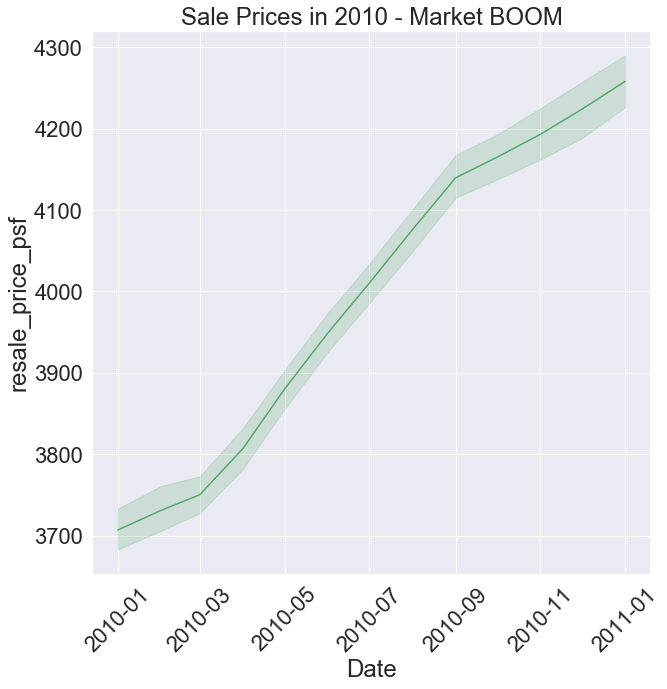

In [133]:
sales_high = sales_df[sales_df['month'].between('2010-01-01', '2011-01-01')]

sns.set(rc={'figure.figsize':(10,10)}, font_scale = 2)
sns.lineplot(x = 'month', y = 'resale_price_psf', data = sales_high, c = 'g')
plt.title('Sale Prices in 2010 - Market BOOM')
plt.xticks(rotation = 45)
plt.xlabel('Date')

Text(0.5, 0, 'Date')

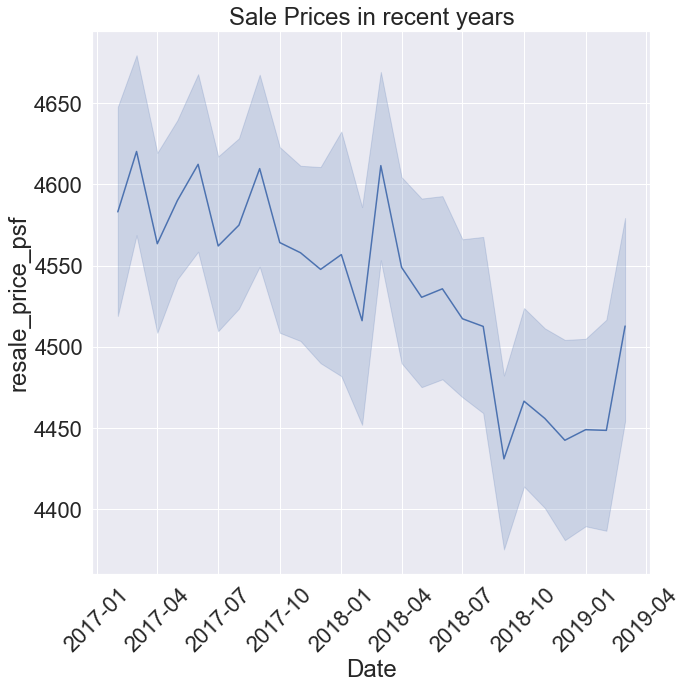

In [134]:
sales_const = sales_df[sales_df['month'] > '2017-01-01']

sns.set(rc={'figure.figsize':(10,10)}, font_scale = 2)
sns.lineplot(x = 'month', y = 'resale_price_psf', data = sales_const, color = 'b')
plt.title('Sale Prices in recent years')
plt.xticks(rotation = 45)
plt.xlabel('Date')

In [113]:
print('Number of Homes for Declining Sales:', sales_low.shape[0])
print('Number of Homes for Increasing Sales:', sales_high.shape[0])
print('Number of Homes for Constant Sales:', sales_const.shape[0])

Number of Homes for Declining Sales: 56010
Number of Homes for Increasing Sales: 36985
Number of Homes for Constant Sales: 45267


In [114]:
# Save each file to a csv file for book #3

sales_low.to_csv('./resale-flat-prices/declining_sale_price_df.csv')
sales_high.to_csv('./resale-flat-prices/increasing_sale_price_df.csv')
sales_const.to_csv('./resale-flat-prices/constant_sale_price_df.csv')

